# Notebook Iteracion final Modelado

### Objetivo: Crear el modelo final implementando validación cruzada e importancia de vabariables


Nota: En esta iteración se usan algunas librerias adicionales a las programadas en funciones.py, como estas no se reutilizarán en ejecuciones posteriores se dejan como locales para este notebook

In [18]:
# Funciones generales
import sys
sys.path.append('../')
# A medida que avanzan las iteraciones se crearan mas funcinoes transversales
from funciones import *

# Tuneo de hiperparámetros
from sklearn.model_selection import ParameterGrid

# Libreria para manejo de balance de datos
import smogn

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Serializacion
import pickle

# Grid Search Validacion cruzada
from sklearn.model_selection import GridSearchCV

# xgboost
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

**Lectura de datos**

Datos resultantes de la iteración 2

In [19]:
import os 
# get current directory
path = os.getcwd()
# parent directory
path = os.path.abspath('../')
data_model = pd.read_csv(path + "/iteracion_2/datos_iteracion_2.csv")
data_model.head()

,precio,zona,barrio_sector,baños_familiares,area_bruta,numero_niveles,parqueaderos,alcobas_familiares,estrato,area_total,...,closet_de_linos,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,dispositivos_automatizacion,alarma,tipo_cocina_freq,tipo_pisos_freq
0,1100000.0,centro,castilla,1.0,95.0,1.0,0.0,3.0,0.0,95.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
1,950000.0,centro,el salvador,1.0,70.0,1.0,0.0,2.0,3.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
2,970000.0,centro,los angeles,1.0,38.0,1.0,0.0,1.0,4.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
3,1400000.0,centro,prado,1.0,50.0,1.0,1.0,2.0,0.0,50.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
4,800000.0,centro,12 de octubre,1.0,92.0,1.0,0.0,3.0,2.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709


**Variables predictoras**

In [20]:
pred_columns = [
    'baños_familiares',
    'area_bruta', 
    'numero_niveles',
    'parqueaderos', 
    'alcobas_familiares', 
    'estrato', 
    'area_total',
    'juegos_infantiles', 
    'balcon', 
    'zona_ropas', 
    'camaras_cctv',
    'cancha_polideportiva', 
    'ascensor', 
    'cancha_squash', 
    'zona_bbq',
    'patio', 
    'unidad_cerrada_conjunto', 
    'zonas_verdes',
    'aire_acondicionado', 
    'jacuzzi', 
    'red_de_Gas', 
    'turco', 
    'porteria_24_7',
    'sauna', 
    'calentador_de_agua', 
    'terraza', 
    'closet_de_linos',
    'biblioteca', 
    'parqueadero_visitantes', 
    'gimnasio', 
    'piscina',
    'salon_social', 
    'dispositivos_automatizacion', 
    'alarma',
    'tipo_cocina_freq', 
    'tipo_pisos_freq'
]

**Variables predictoras**

En la iteración 2 el analisis de distribución y correlaciones dió como resultado la eliminación de las variables:

- columns_disc_corr
- numero_niveles
- zona_ropas
- camaras_cctv
- cancha_polideportiva
- cancha_squash
- zona_bbq
- patio
- aire_acondicionado
- jacuzzi
- red_de_Gas
- terraza
- dispositivos_automatizacion
- alarma
- area_total
- porteria_24_7

Se reutiliza estas variables, sin embargo por criterio del negocio se conservan las siguientes variables dejando su eliminación para un posterior analisis de importancia de variables:

- cancha_polideportiva


In [21]:
columns_disc_corr = [
    "numero_niveles",
    "zona_ropas",
    "camaras_cctv",
    "cancha_squash",
    "zona_bbq",
    "patio",
    "aire_acondicionado",
    "jacuzzi",
    "red_de_Gas",
    "terraza",
    "dispositivos_automatizacion",
    "alarma",
    "area_total",
    "porteria_24_7"
]

**Estandarización**

In [22]:
X = data_model[pred_columns]
Y = data_model['precio']

In [23]:
X_est = estandarizar(X)

**Clustering**

Se procede con la ejecucion del algoritmo de kmeans entre las variables __precio__ y __area_bruta__, esta última por ser la mas relevante en la ejecución del modelo línea base y el análisis de correlaciones

In [24]:
X_est['precio'] = Y.values

In [25]:
x_cluster = X_est[['precio', 'area_bruta']].values
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans_labels = kmeans.fit_predict(x_cluster)
    sample_silhouette_values = silhouette_samples(x_cluster, kmeans_labels)
    print("silhouette_score k = {} : {}".format(k , sample_silhouette_values.mean()))

silhouette_score k = 2 : 0.5965131713561477
silhouette_score k = 3 : 0.6348158925476787
silhouette_score k = 4 : 0.6058642604255898
silhouette_score k = 5 : 0.5952737314776967


Segun el cálculo del coeficiente de siluetas se obtiene un mejor resultado para 3 clusters, se selecciona este valor para hacer la división de los datos

Entrenamiento y calculo de las etiquetas de los clusters

In [26]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans_labels = kmeans.fit_predict(x_cluster)

Se añade la etiqueta cluster como nueva variable de la base de entrenamiento

In [27]:
X_est['cluster'] = kmeans_labels

Los rangos de precios de cada cluster son:

In [28]:
print("Cluster 0: ", X_est[X_est['cluster']==0]['precio'].min(), X_est[X_est['cluster']==0]['precio'].max())
print("Cluster 1: ", X_est[X_est['cluster']==1]['precio'].min(), X_est[X_est['cluster']==1]['precio'].max())
print("Cluster 2: ", X_est[X_est['cluster']==2]['precio'].min(), X_est[X_est['cluster']==2]['precio'].max())

Cluster 0:  500000.0 2700000.0
Cluster 1:  2750000.0 5500000.0
Cluster 2:  5600000.0 9500000.0


Serialización del modelo clustering

In [29]:
with open('kmeans_arriendos.pkl', 'wb') as pickle_file:
    pickle.dump(kmeans, pickle_file) 

**Modelo**

Se ejecuta un proceso de entrenamiento incluyendo el método de validación cruzada para obtener el modelo final

Se eliminan las variables de la base de modelado dado los anteriores análisis

In [30]:
x_model = X_est.drop(columns = columns_disc_corr)
x_model = x_model.drop(columns='precio')
y_model = X_est['precio']
imprimir_dimensiones(x_model)

Numero de muestras: 2892, Número de columnas: 23


**Dvisión de los datos:** Entrenamiento 75%, Test 25%

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, test_size = 0.25, train_size = 0.75, random_state = 17)
print("Tamaño de los Datos de Entrenamiento = ", x_train.shape)
print("Tamaño de los Datos de Validación = ", x_test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", y_train.shape)
print("Tamaño del Vector de Clases de Prueba = ", y_test.shape)

Tamaño de los Datos de Entrenamiento =  (2169, 23)
Tamaño de los Datos de Validación =  (723, 23)
Tamaño del Vector de Clases de Entrenamiento =  (2169,)
Tamaño del Vector de Clases de Prueba =  (723,)


**XGBOOST**

In [32]:
for column in x_train.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_train[column] = x_train[column].astype('float') 

for column in x_test.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_test[column] = x_test[column].astype('float') 

Entrenamiento del modelo por medio de validación cruzada

In [33]:
param_grid_xgb = {
    'n_estimators' : [80, 100],
    'max_depth' : [5, 7],
    'learning_rate' : [.03,.05],
    'objective' : ['reg:squarederror'],
    'subsample' : [0.3, 0.5,0.8],
    'eta' : [.01,.05],
}

grid = GridSearchCV(
        estimator  = xgb.XGBRegressor(random_state=123),
        param_grid = param_grid_xgb,
        scoring    = 'r2',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=x_train, y= y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05], 'learning_rate': [0.03, 0.05],
                         'max_depth': [5, 7], 'n_estimators': [80, 100],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.3, 0.5, 0.8]},
             return_train_score=True, scoring='r2')

Obtencion de los resultados de las diferentes combinaciones de hiperparámetros

In [34]:
resultados_cv = pd.DataFrame(grid.cv_results_)
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_eta,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
40,0.05,0.05,5,100,reg:squarederror,0.5,0.923038,0.001801,0.953137,0.000460
16,0.01,0.05,5,100,reg:squarederror,0.5,0.923038,0.001801,0.953137,0.000460
41,0.05,0.05,5,100,reg:squarederror,0.8,0.922232,0.003080,0.956403,0.000533
17,0.01,0.05,5,100,reg:squarederror,0.8,0.922232,0.003080,0.956403,0.000533
45,0.05,0.05,7,100,reg:squarederror,0.3,0.921843,0.001746,0.962056,0.000513
21,0.01,0.05,7,100,reg:squarederror,0.3,0.921843,0.001746,0.962056,0.000513
22,0.01,0.05,7,100,reg:squarederror,0.5,0.921533,0.002300,0.969383,0.000658
46,0.05,0.05,7,100,reg:squarederror,0.5,0.921533,0.002300,0.969383,0.000658
37,0.05,0.05,5,80,reg:squarederror,0.5,0.921520,0.002373,0.947263,0.000338
13,0.01,0.05,5,80,reg:squarederror,0.5,0.921520,0.002373,0.947263,0.000338


In [41]:
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .to_csv("xgoost_iteraciones_cv.csv", index=False)

Mejor combinación de hiperparámetros

In [35]:
grid.best_params_

{'eta': 0.01,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

Mejor modelo

In [36]:
xgb_final = grid.best_estimator_

Métricas del mejor modelo

In [37]:
resultados = {'R2_train': [],
               'R2_test': [],
               'RMSE_train': [],
               'RMSE_test': [],
               'MAPE_train': [],
               'MAPE_test': [],}
resultados['R2_train'].append(r2_score(y_true=y_train, y_pred=xgb_final.predict(x_train)))
resultados['R2_test'].append(r2_score(y_true=y_test, y_pred=xgb_final.predict(x_test)))
resultados['RMSE_train'].append(mean_squared_error(y_true=y_train, y_pred=xgb_final.predict(x_train), squared=False))
resultados['RMSE_test'].append(mean_squared_error(y_true=y_test, y_pred=xgb_final.predict(x_test), squared=False))
resultados['MAPE_train'].append(mean_absolute_percentage_error(y_true=y_train, y_pred  = xgb_final.predict(x_train)))
resultados['MAPE_test'].append(mean_absolute_percentage_error(y_true=y_test, y_pred  = xgb_final.predict(x_test)))
pd.DataFrame(resultados)

,R2_train,R2_test,RMSE_train,RMSE_test,MAPE_train,MAPE_test
0,0.950208,0.913734,461855.190478,606713.786397,0.122231,0.151518


Cálculo de importancia de variables

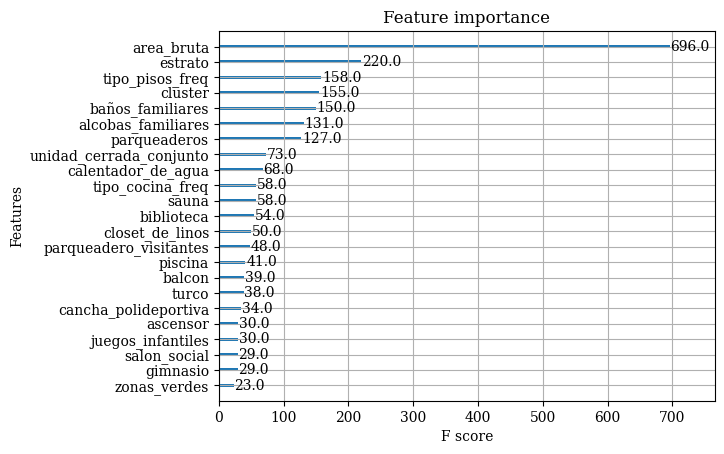

<Figure size 1600x1600 with 0 Axes>

In [38]:
xgb.plot_importance(xgb_final)
plt.figure(figsize = (16, 16))
plt.show()

Serialización del modelo final

In [40]:
with open('xgboost_arriendos.pkl', 'wb') as pickle_file:
    pickle.dump(xgb_final, pickle_file) 

**Conclusiones:**

- La predicción de precios de arriendos en la ciudad de Medellín se soluciona mediante la creación de un proceso de scraping, la implementación de un algoritmo kmeans como parte del proceso de feature engineering y el entrenamiento de un modelo xgboost
- Se obtiene un modelo xgboost con las caracteristicas deseadas por el negocio (MAPE <= 0.15), con la ventaja de contar con la cobertura de todas las zonas consultadas en el proceso de extracción de información
- La variable __area_bruta__, predomina en importancia en este modelo, lo que indica la alta influencia que tiene el tamaño de una vivienda en su precio. se nota también variables como __tipo_pisos_freq__ y __cluster__ son bastante influyentes, siendo estas resultado del proceso de tratamiento de la información se evidencia la importancia que tuvo este proceso.
- No se evidencia variables con importancia 0 o cercano a este valor en ninguna de las variables, por tanto, no se ejecuta eliminación de variables por este criterio